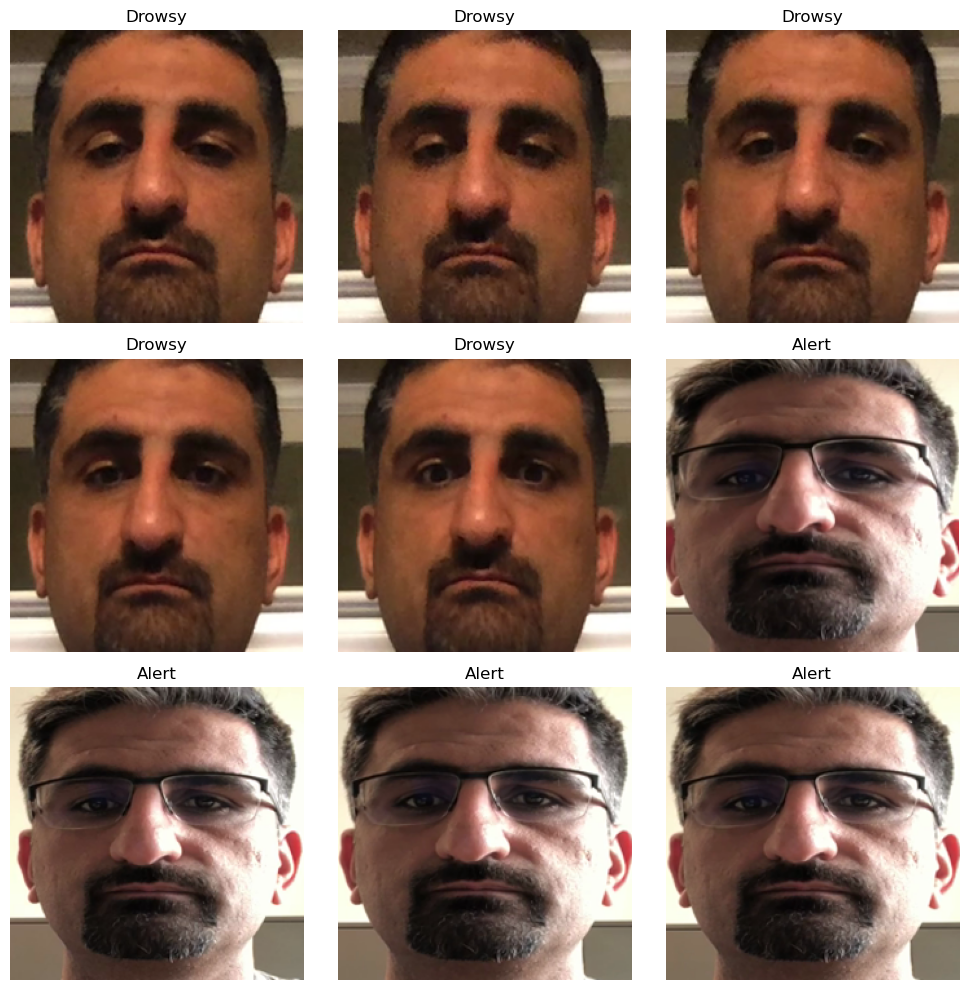

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "./"

# Get image paths
drowsy_images = [os.path.join(dataset_path, "Drowsy", img) for img in os.listdir(os.path.join(dataset_path, "Drowsy"))]
alert_images = [os.path.join(dataset_path, "NonDrowsy", img) for img in os.listdir(os.path.join(dataset_path, "NonDrowsy"))]

# Combine images and labels
image_paths = drowsy_images[:5] + alert_images[:4]  # Display first 5 drowsy and first 4 alert images for example
labels = ["Drowsy"] * 5 + ["Alert"] * 4

# Plot images
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [3]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts image to PyTorch Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load the dataset from directory
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Define a CNN model for drowsiness detection
class DrowsinessModel(nn.Module):
    def __init__(self):
        super(DrowsinessModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor for fully connected layer
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Instantiate the model
model = DrowsinessModel()

In [6]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight_decay


In [7]:
import torch.optim as optim

In [8]:
# Training loop with accuracy calculation
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Calculate accuracy for training
        predicted = (outputs > 0.5).float()  # Apply threshold to get binary predictions
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            
            # Calculate accuracy for validation
            predicted = (outputs > 0.5).float()  # Apply threshold to get binary predictions
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("Training complete!")

Epoch 1/10, Training Loss: 0.0472, Training Accuracy: 98.27%, Validation Loss: 0.0147, Validation Accuracy: 99.69%
Epoch 2/10, Training Loss: 0.0051, Training Accuracy: 99.86%, Validation Loss: 0.0065, Validation Accuracy: 99.86%
Epoch 3/10, Training Loss: 0.0104, Training Accuracy: 99.82%, Validation Loss: 0.0017, Validation Accuracy: 99.95%
Epoch 4/10, Training Loss: 0.0113, Training Accuracy: 99.78%, Validation Loss: 0.0013, Validation Accuracy: 99.94%
Epoch 5/10, Training Loss: 0.0007, Training Accuracy: 99.98%, Validation Loss: 0.0002, Validation Accuracy: 99.99%
Epoch 6/10, Training Loss: 0.0000, Training Accuracy: 100.00%, Validation Loss: 0.0005, Validation Accuracy: 99.99%
Epoch 7/10, Training Loss: 0.0048, Training Accuracy: 99.87%, Validation Loss: 0.0004, Validation Accuracy: 99.99%
Epoch 8/10, Training Loss: 0.0055, Training Accuracy: 99.88%, Validation Loss: 0.0098, Validation Accuracy: 99.75%
Epoch 9/10, Training Loss: 0.0035, Training Accuracy: 99.92%, Validation Loss: 